In [2]:
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 100
rcParams["savefig.dpi"] = 150

# import maelstrom as ms
import numpy as np
#import corner
import pandas as pd
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm



In [3]:
from astropy.stats import LombScargle
from astropy.convolution import convolve, Box1DKernel
import math

def amp_spectrum(t, y, fmin=None, fmax=None, nyq_mult=1., oversample_factor=5.):
    tmax = t.max()
    tmin = t.min()
    df = 1.0 / (tmax - tmin)
    
    if fmin is None:
        fmin = df
    if fmax is None:
        fmax = (0.5 / np.median(np.diff(t)))*nyq_mult

    freq = np.arange(fmin, fmax, df / oversample_factor)
    model = LombScargle(t, y)
    sc = model.power(freq, method="fast", normalization="psd")

    fct = np.sqrt(4./len(t))
    amp = np.sqrt(sc) * fct
    
    return freq, amp


def smooth(freq, power, method='boxkernel', filter_width=0.1):

    if method == 'boxkernel':
        if filter_width <= 0.:
            raise ValueError("the `filter_width` parameter must be "
                             "larger than 0 for the 'boxkernel' method.")
        fs = np.mean(np.diff(freq))
        box_kernel = Box1DKernel(math.ceil((filter_width/fs)))
        smooth_power = convolve(power, box_kernel)
        return smooth_power

    if method == 'logmedian':
        count = np.zeros(len(freq), dtype=int)
        bkg = np.zeros_like(freq)
        x0 = np.log10(freq[0])
        while x0 < np.log10(freq[-1]):
            m = np.abs(np.log10(freq) - x0) < filter_width
            if len(bkg[m] > 0):
                bkg[m] += np.nanmedian(power)
                count[m] += 1
            x0 += 0.5 * filter_width
        bkg /= count
        smooth_power = bkg
        return smooth_power

In [4]:
from exoplanet.utils import eval_in_model
from exoplanet.orbits import get_true_anomaly
import pymc3 as pm
import theano.tensor as tt

class SyntheticBinary(object):
    """
    This class makes a synthetic light curve and injects a time delay signal corresponding to the input binary orbit parameters    
    """
    def __init__(self, time, freq, amplitude, 
                 period, eccen, asini, varpi, tref):
        self.time = time
        self.freq = freq
        self.amplitude = amplitude
        self.period, self.eccen, self.asini, self.varpi, self.tref = period, eccen, asini, varpi, tref
        
        self.make_lightcurve()
        self.flux = self.flux_true
        
    def make_lightcurve(self):
        self.flux_true = np.zeros(len(self.time))
        
        with pm.Model() as model:
            #M = tt.zeros_like(tt.constant(self.time) - self.tref) + 2.0 * np.pi * (tt.constant(self.time)) / self.period
            M = 2.0 * np.pi * (tt.constant(self.time) - self.tref) / self.period
            f = get_true_anomaly(M, self.eccen + tt.zeros_like(M))
            tau_tens = (- (1 - tt.square(self.eccen)) * tt.sin(f+self.varpi) / (1 + self.eccen*tt.cos(f))) * (self.asini / 86400.)
            self.tau = eval_in_model(tau_tens)
            
        for j, A_j in zip(self.freq, self.amplitude):
            omega = 2 * np.pi * j
            self.flux_true += A_j * np.cos(omega * (self.time - self.tau)) + A_j * np.sin(omega * (self.time - self.tau))
            
    def add_noise(self, snr=5):
        # Add noise
        np.random.seed(42)
        s_rms = self.amplitude / (np.sqrt(np.pi / len(self.time)) * snr)
        #print(s_rms, self.amplitude)
        #print(np.random.normal(loc=0.0, scale=s_rms, size=len(self.time)))
        self.flux = self.flux_true + np.random.normal(loc=0.0, scale=s_rms, size=len(self.time))
        #self.flux_err = noise * np.std(self.flux_true)
        #self.flux = self.flux_true + self.flux_err * np.random.randn(len(self.flux_true))

In [27]:
import astropy.units as u

In [31]:
u.day

Unit("d")

In [41]:
from astropy import constants as const
1*const.G

<Quantity 6.67408e-11 m3 / (kg s2)>

In [42]:
from astropy import constants as const

def mass_function(period, asini):
    return (4*np.pi**2) / (1*const.G) * ((asini)**3) / ((period).to(u.s)**2)

In [43]:
mass_function(100*u.d, 50*u.s)

<Quantity 990.49173656 kg s3 / m3>

In [7]:
from maelstrom import Maelstrom

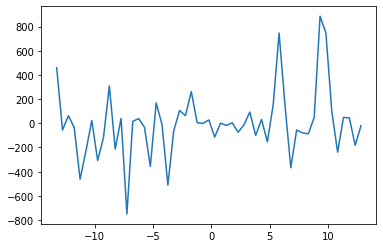

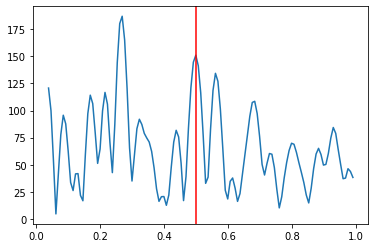

In [10]:
# Check time delay signal is injected properly
period = 2.
eccen = 0.
asini = 100
varpi = 1.
tref = 0.

n_freq = 1
np.random.seed(42)
freqs = np.random.normal(40, 20, size=n_freq)

np.random.seed(23)
amps = np.random.normal(0.001, 0.01, size=n_freq)

# TESS 2 min cadence for 1 sector
time = np.arange(0, 27, 1.0 / (24 * 30))

lc = SyntheticBinary(time, freqs, amps,
                     period, eccen, asini, varpi, tref)
lc.add_noise(snr=5.)

ms = Maelstrom(lc.time, lc.flux, freq=freqs)
td_time, td_td = ms.get_time_delay(segment_size=0.5)
plt.plot(td_time, td_td)

plt.show()

plt.plot(*amp_spectrum(td_time, td_td[:,0]))
plt.axvline(1/period, c='r')

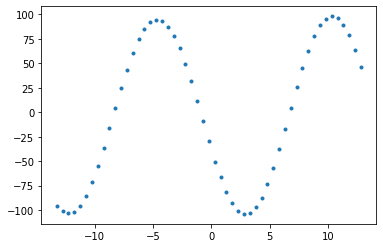

In [11]:
# Check time delay signal is injected properly
period = 15.
eccen = 0.
asini = 100
varpi = 1.
tref = 0.

n_freq = 1
freqs = [20]
amps = [0.1]

# TESS 2 min cadence for 1 sector
time = np.arange(0, 27, 1.0 / (24 * 30))

lc = SyntheticBinary(time, freqs, amps,
                     period, eccen, asini, varpi, tref)
#lc.add_noise(noise=1.)

ms = Maelstrom(lc.time, lc.flux, freq=freqs)
td_time, td_td = ms.get_time_delay(segment_size=0.5)
plt.plot(td_time, td_td, '.')

# Change snr

In [12]:
import pymc3 as pm
import theano
from tqdm import tqdm as tqdm
import numpy as np
import exoplanet as xo
import theano.tensor as tt

time_tensor = theano.shared(lc.time)
flux_tensor = theano.shared(lc.flux)

with pm.Model() as simple_model:
    
    period = pm.Flat("period", testval=10.0)
    nu = pm.Flat("nu", testval=15)
    
    phi = xo.distributions.Angle("phi")
    logasini = pm.Uniform("logasini", lower=np.log(1), upper=np.log(1000),
                          testval=np.log(10))
    drift = pm.Normal("drift", mu=0, sd=1.0)
    
    M = 2.0 * np.pi * time_tensor / period - phi
    
    factor = 2. * np.pi * nu
    A = factor * (1 + drift) * time_tensor
    B = -factor * (tt.exp(logasini) / 86400) * tt.sin(M)
    
    sinarg = tt.sin(A+B)
    cosarg = tt.cos(A+B)
    
    DT = tt.stack((sinarg, cosarg, tt.ones_like(sinarg)))
    w = tt.slinalg.solve(tt.dot(DT, DT.T), tt.dot(DT, flux_tensor))
    pm.Deterministic("w", w)
    pm.Deterministic("phase", tt.arctan2(w[1], w[0]))
    lc_model = tt.dot(DT.T, w)
        
    pm.Normal("obs", mu=lc_model, observed=flux_tensor)
    
    fit_params = [v for v in simple_model.vars if v.name not in ["period", "nu"]]

def run_fit(p, nu):
    with simple_model:
        start = dict(simple_model.test_point)
        start["period"] = p
        start["nu"] = nu
        point, info = xo.optimize(start, vars=fit_params, return_info=True, verbose=False)
    return -info.fun, point

In [18]:
snr

0.0

In [26]:
snrs = np.geomspace(1,30,40)
periods = np.geomspace(1, 50, 50)

period = 15.
eccen = 0.
asini = 100
varpi = 1.
tref = 0.
n_freq = 1
freqs = [20]
amps=[0.1]

# TESS 2 min cadence for 1 sector
time = np.arange(0, 27, 1.0 / (24 * 30))

results = []
snr_arr = []
for snr in snrs:
    lc = SyntheticBinary(time, freqs, amps,
                     period, eccen, asini, varpi, tref)
    lc.add_noise(snr=snr)
    
    time_tensor.set_value(lc.time)
    flux_tensor.set_value(lc.flux)
    
    for f in freqs:
        results.append([run_fit(p, f) for p in tqdm(periods)])
        
        
    # calculate SNR
    freq, amp = amp_spectrum(lc.time, lc.flux, fmin=15., fmax=25.)
    smoothed = smooth(freq, amp, filter_width=0.01, method='logmedian')
    val = amp / smoothed
    snr_arr.append(np.max(val))


100%|██████████| 50/50 [00:58<00:00,  1.16s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

100%|██████████| 50/50 [00:58<00:00,  1.13s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

 98%|█████████▊| 49/50 [00:56<00:01,  1.14s/it]


100%|██████████| 50/50 [00:57<00:00,  1.13s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

100%|██████████| 50/50 [00:57<00:00,  1.16s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

100%|██████████| 50/50 [00:57<00:00,  1.26s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

 86%|████████▌ | 43/50 [00:48<00:07,  1.13s/it]


100%|██████████| 50/50 [00:56<00:00,  1.12s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

100%|██████████| 50/50 [00:57<00:00,  1.10s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

100%|██████████| 50/50 [00:58<00:00,  1.28s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

 74%|███████▍  | 37/50 [00:47<00:15,  1.16s/it]


100%|██████████| 50/50 [01:02<00:00,  1.18s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

100%|██████████| 50/50 [00:58<00:00,  1.17s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

100%|██████████| 50/50 [00:57<00:00,  1.09s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

 62%|██████▏   | 31/50 [00:38<00:22,  1.19s/it]


100%|██████████| 50/50 [01:01<00:00,  1.10s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

100%|██████████| 50/50 [01:03<00:00,  1.24s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

100%|██████████| 50/50 [00:56<00:00,  1.16s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

 50%|█████     | 25/50 [00:28<00:30,  1.23s/it]


100%|██████████| 50/50 [00:57<00:00,  1.16s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

100%|██████████| 50/50 [01:00<00:00,  1.16s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

100%|██████████| 50/50 [00:59<00:00,  1.09s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

 38%|███▊      | 19/50 [00:20<00:33,  1.08s/it]


100%|██████████| 50/50 [00:55<00:00,  1.14s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

100%|██████████| 50/50 [01:06<00:00,  1.21s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

100%|██████████| 50/50 [00:59<00:00,  1.24s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

 26%|██▌       | 13/50 [00:15<00:45,  1.22s/it]


100%|██████████| 50/50 [00:56<00:00,  1.11s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

100%|██████████| 50/50 [00:58<00:00,  1.26s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

100%|██████████| 50/50 [01:01<00:00,  1.31s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

 14%|█▍        | 7/50 [00:08<00:54,  1.26s/it]


100%|██████████| 50/50 [00:58<00:00,  1.10s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

100%|██████████| 50/50 [00:58<00:00,  1.38s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

100%|██████████| 50/50 [00:59<00:00,  1.24s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

  2%|▏         | 1/50 [00:01<01:06,  1.36s/it]


100%|██████████| 50/50 [00:58<00:00,  1.11s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

100%|██████████| 50/50 [00:56<00:00,  1.19s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

100%|██████████| 50/50 [00:57<00:00,  1.18s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]



100%|██████████| 50/50 [01:02<00:00,  1.15s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

100%|██████████| 50/50 [01:06<00:00,  1.38s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

 98%|█████████▊| 49/50 [01:06<00:01,  1.25s/it]


100%|██████████| 50/50 [01:07<00:00,  1.20s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

100%|██████████| 50/50 [01:00<00:00,  1.22s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

100%|██████████| 50/50 [00:57<00:00,  1.15s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

 86%|████████▌ | 43/50 [00:47<00:07,  1.13s/it]


100%|██████████| 50/50 [00:55<00:00,  1.12s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

100%|██████████| 50/50 [00:55<00:00,  1.14s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

100%|██████████| 50/50 [01:05<00:00,  1.44s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

 74%|███████▍  | 37/50 [00:54<00:18,  1.43s/it]


100%|██████████| 50/50 [01:14<00:00,  1.58s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

100%|██████████| 50/50 [01:24<00:00,  1.74s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]

100%|██████████| 50/50 [01:14<00:00,  1.55s/it]WARNING: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead [astropy.stats.lombscargle]


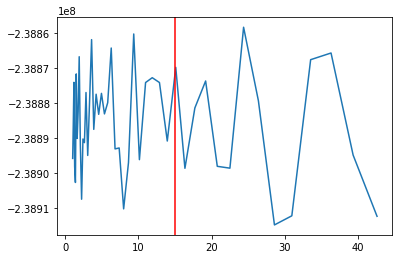

In [22]:
ys_like = np.array([[r[0] for r in row] for row in results])
sm = np.sum(ys_like, axis=0)
period_ind = np.argmax(sm)
plt.plot(periods[:-2], sm[:-2]);
plt.axvline(15., c='r')

In [25]:
snrs

array([ 0.1       ,  0.11574865,  0.1339775 ,  0.15507714,  0.1794997 ,
        0.20776847,  0.2404892 ,  0.278363  ,  0.32220141,  0.37294378,
        0.43167738,  0.49966074,  0.57835055,  0.66943295,  0.77485959,
        0.89688951,  1.03813749,  1.20163011,  1.39087062,  1.60991395,
        1.86345364,  2.15692241,  2.49660854,  2.88979065,  3.34489362,
        3.87166917,  4.48140475,  5.18716544,  6.0040739 ,  6.94963441,
        8.04410792,  9.31094621, 10.77729442, 12.47457266, 14.43914929,
       16.71312019, 19.34521077, 22.39182006, 25.91822914, 30.        ])

Text(0, 0.5, 'asini (s)')

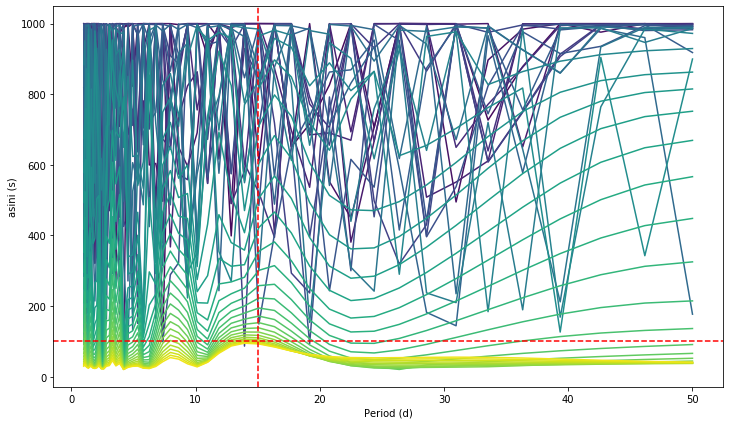

In [24]:
from maelstrom.utils import unique_colors


plt.figure(figsize=[12,7])

ys = np.array([[np.exp(r[1]["logasini"]) for r in row] for row in results])
for color, val in zip(unique_colors(len(snrs), cmap="viridis"), ys):
    plt.plot(periods, val, c=color)
plt.axvline(15, c='r', linestyle='--')
plt.axhline(100, c='r', linestyle='--')
plt.xlabel('Period (d)')
plt.ylabel('asini (s)')

Text(0, 0.5, 'SNR')

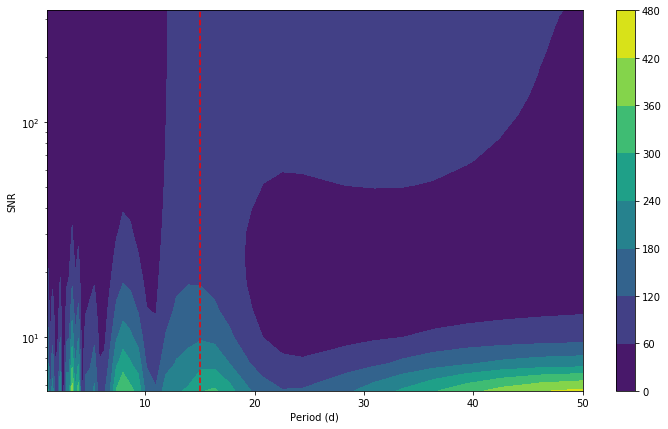

In [89]:
plt.figure(figsize=[12,7])

X, Y = np.meshgrid(periods, snr)
plt.contourf(X, Y, ys)
plt.colorbar()
plt.axvline(15., linestyle='--', c='r')
plt.yscale('log')
plt.xlabel('Period (d)')
plt.ylabel('SNR')

Text(0, 0.5, 'SNR')

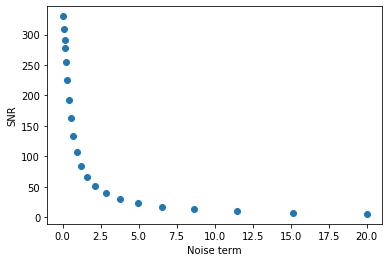

In [91]:
plt.scatter(noises, snr)
plt.xlabel('Noise term')
plt.ylabel('SNR')

### Is frequency crowding equivalent to changing the SNR?

In [96]:
period = 15.
eccen = 0.
asini = 100
varpi = 1.
tref = 0.
n_freq = 1

# TESS 2 min cadence for 1 sector
time = np.arange(0, 27, 1.0 / (24 * 30))

In [97]:
from scipy.stats import skew

noises = np.append([0],np.geomspace(0.1,20,20))
freqs = [20]
amps=[0.1]

snr = []
for noise in noises:
    lc = SyntheticBinary(time, freqs, amps,
                     period, eccen, asini, varpi, tref)
    lc.add_noise(noise=noise)
    
    # calculate SNR
    freq, amp = amp_spectrum(lc.time, lc.flux, fmin=15., fmax=25.)
    smoothed = smooth(freq, amp, filter_width=0.01, method='logmedian')
    val = amp / smoothed
    snr.append(np.max(val))

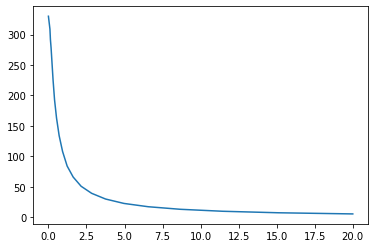

In [98]:
plt.plot(noises, snr)

In [106]:
from scipy.stats import skew

period = 15.
eccen = 0.
asini = 100
varpi = 1.
tref = 0.

test = []
snr = []
n_freqs = range(1,100)
for n_freq in n_freqs:
    #n_freq = 100
    np.random.seed(42)
    freqs = np.random.normal(20, 0.1, size=n_freq)
    amps = [0.1]*n_freq

    # TESS 2 min cadence for 1 sector
    time = np.arange(0, 27, 1.0 / (24 * 30))

    lc = SyntheticBinary(time, freqs, amps,
                         period, eccen, asini, varpi, tref)
    #lc.add_noise(noise=1.)
    ff,aa = amp_spectrum(lc.time, lc.flux)
    test.append(skew(aa))
    
    smoothed = smooth(ff, aa, filter_width=0.01, method='logmedian')
    val = aa / smoothed
    snr.append(np.max(val))

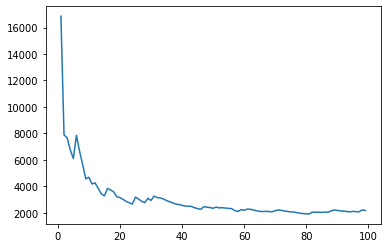

In [115]:
plt.plot(n_freqs, snr)

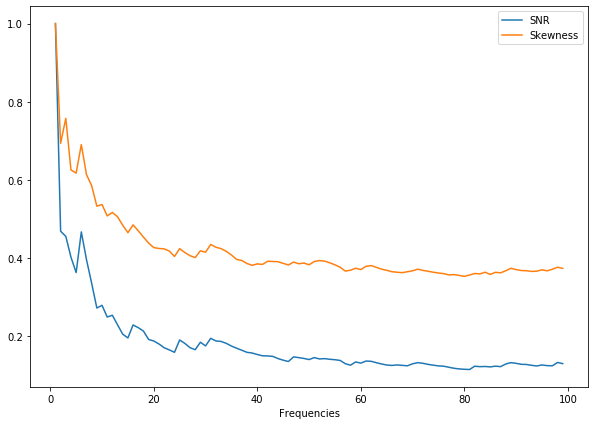

In [114]:
plt.figure(figsize=[10,7])

plt.plot(n_freqs, snr / np.max(snr), label='SNR')
plt.plot(n_freqs, test / np.max(test), label='Skewness')
plt.xlabel('Frequencies')
plt.legend()

# Frequency crowding

In [9]:
from scipy.stats import skew

period = 15.
eccen = 0.
asini = 100
varpi = 1.
tref = 0.

test = []
for n_freq in range(1,100):
    #n_freq = 100
    np.random.seed(42)
    freqs = np.random.normal(40, 20, size=n_freq)

    np.random.seed(23)
    amps = np.random.normal(0.001, 0.01, size=n_freq)

    # TESS 2 min cadence for 1 sector
    time = np.arange(0, 27, 1.0 / (24 * 30))

    lc = SyntheticBinary(time, freqs, amps,
                         period, eccen, asini, varpi, tref)
    #lc.add_noise(noise=1.)
    ff,aa = amp_spectrum(lc.time, lc.flux)
    test.append(skew(aa))

Text(0, 0.5, 'Skew')

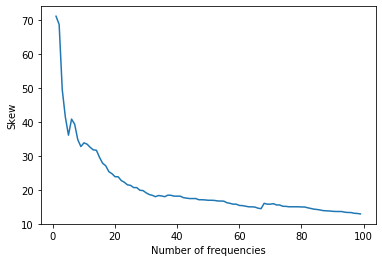

In [10]:
plt.plot(list(range(1,100)), test)
plt.xlabel('Number of frequencies')
plt.ylabel('Skew')

In [28]:
import pymc3 as pm
import theano
from tqdm import tqdm as tqdm
import numpy as np
import exoplanet as xo
import theano.tensor as tt

time_tensor = theano.shared(lc.time)
flux_tensor = theano.shared(lc.flux)

with pm.Model() as simple_model:
    
    period = pm.Flat("period", testval=10.0)
    nu = pm.Flat("nu", testval=15)
    
    phi = xo.distributions.Angle("phi")
    logasini = pm.Uniform("logasini", lower=np.log(1), upper=np.log(1000),
                          testval=np.log(10))
    drift = pm.Normal("drift", mu=0, sd=1.0)
    
    M = 2.0 * np.pi * time_tensor / period - phi
    
    factor = 2. * np.pi * nu
    A = factor * (1 + drift) * time_tensor
    B = -factor * (tt.exp(logasini) / 86400) * tt.sin(M)
    
    sinarg = tt.sin(A+B)
    cosarg = tt.cos(A+B)
    
    DT = tt.stack((sinarg, cosarg, tt.ones_like(sinarg)))
    w = tt.slinalg.solve(tt.dot(DT, DT.T), tt.dot(DT, flux_tensor))
    pm.Deterministic("w", w)
    pm.Deterministic("phase", tt.arctan2(w[1], w[0]))
    lc_model = tt.dot(DT.T, w)
        
    pm.Normal("obs", mu=lc_model, observed=flux_tensor)
    
    fit_params = [v for v in simple_model.vars if v.name not in ["period", "nu"]]

def run_fit(p, nu):
    with simple_model:
        start = dict(simple_model.test_point)
        start["period"] = p
        start["nu"] = nu
        point, info = xo.optimize(start, vars=fit_params, return_info=True, verbose=False)
    return -info.fun, point

In [16]:
n_frequencies = range(1,3,1)

period = 15.
eccen = 0.
asini = 100
varpi = 1.
tref = 0.

# TESS 2 min cadence for 1 sector
time = np.arange(0, 27, 1.0 / (24 * 30))

# Periods to search over
periods = np.geomspace(1, 50, 50)
skews = []
results = []

for n_frequency in n_frequencies:
    # Generate synthetic binary LC
    np.random.seed(42)
    freqs = np.random.normal(40, 20, size=n_frequency)
    np.random.seed(23)
    amps = np.random.normal(0.001, 0.01, size=n_frequency)

    lc = SyntheticBinary(time, freqs, amps, period, eccen, asini, varpi, tref)
    #lc.add_noise(noise=1.)
    ls_freq, ls_amp = amp_spectrum(lc.time, lc.flux)
    skews.append(skew(ls_amp))
    
    # Update shared theano values
    time_tensor.set_value(lc.time)
    flux_tensor.set_value(lc.flux)
    
    opt_results = []
    for f in freqs:
        opt_results.append([run_fit(p, f) for p in tqdm(periods)])
        
    results.append(opt_results)

100%|██████████| 50/50 [00:57<00:00,  1.11s/it]


In [ ]:
def run_fit_parallel(p):
    with simple_model:
        start = dict(simple_model.test_point)
        start["period"] = p
        start["nu"] = nu
        point, info = xo.optimize(start, vars=fit_params, return_info=True, verbose=False)
    return -info.fun, point

In [ ]:
n_frequencies = range(1,3,1)

period = 15.
eccen = 0.
asini = 100
varpi = 1.
tref = 0.

# TESS 2 min cadence for 1 sector
time = np.arange(0, 27, 1.0 / (24 * 30))
# Periods to search over
periods = np.geomspace(1, 50, 50)

skews, results = [], []

for n_frequency in n_frequencies:
    # Generate synthetic binary LC
    np.random.seed(42)
    freqs = np.random.normal(40, 20, size=n_frequency)
    np.random.seed(23)
    amps = np.random.normal(0.001, 0.01, size=n_frequency)

    lc = SyntheticBinary(time, freqs, amps, period, eccen, asini, varpi, tref)
    #lc.add_noise(noise=1.)
    
    ls_freq, ls_amp = amp_spectrum(lc.time, lc.flux)
    skews.append(skew(ls_amp))
    
    # Update shared theano values
    time_tensor.set_value(lc.time)
    flux_tensor.set_value(lc.flux)
    
    opt_results = []
    for f in freqs:
        with Pool() as pool:
            opt_results = pool.map(run_fit, periods)
        
    results.append(opt_results)